# Статистика, DS-поток
## Задание SP.7

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Баллы за задание:**

* Задача 1 &mdash; 40 баллов;
* Задача 2 &mdash; 30 баллов;
* Задача 3 &mdash; 30 баллов;
* Задача 4 &mdash; 30 баллов;
* Задача 5 &mdash; 60 баллов.

**Важность задач:**

* *высокая:* задачи 1, 5;
* *средняя:* задача 3, 4;
* *обычная:* задача 2.

<b><font size="5">Дорешка:</font></b>

* <b><font size="4">Задача 1</font></b>
  * <b><font color="#00b565" size="3">Добавил пояснения</font></b>
  * <b><font color="#00b565" size="3">Сравнил интервалы случайного леса и ридж регрессии</font></b>
  * <b><font color="#00b565" size="3">Добавил центральный интервал</font></b>
  * <b><font color="#00b565" size="3">Добавил нормальный интервал</font></b>
  * <b><font color="#00b565" size="3">Добавил визуализацию</font></b>

* <b><font size="4">Задача 2</font></b>
  * <b><font color="#00b565" size="3">Добавил пояснения к алгоритму</font></b>
  * <b><font color="#00b565" size="3">Исправил ошибку в краевых случаях</font></b>

In [1]:
# Bot check

# HW_ID: ds_sp7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_california_housing

from sklearn.metrics import (
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape,
    mean_squared_error as mse,
)

from sklearn.utils import resample

from sklearn.neighbors import KernelDensity, KNeighborsRegressor

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_regression import KernelReg

sns.set(style="whitegrid", font_scale=1.3, palette="Set2")

___
### Задача 1.

Для данных из задачи ML.5.2 рассмотрим две модели: случайный лес и ридж-регрессия. Постройте бутстрепные доверительные интервалы трех типов для метрик MSE, MAE, MAPE этих двух моделей.

**Решение:**

In [3]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=17
)

In [4]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

mse_sample_ridge = (y_test - ridge_model.predict(X_test)) ** 2
mae_sample_ridge = np.abs(y_test - ridge_model.predict(X_test))
mape_sample_ridge = np.abs(y_test - ridge_model.predict(X_test)) / np.abs(ridge_model.predict(X_test))

forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)

mse_sample_forest = (y_test - forest_model.predict(X_test)) ** 2
mae_sample_forest = np.abs(y_test - forest_model.predict(X_test))
mape_sample_forest = np.abs(y_test - forest_model.predict(X_test)) / np.abs(forest_model.predict(X_test))

In [5]:
def compute_confidence_interval(sample, bootstrap_samples_cnt=10000, alpha=0.95):
    bootstrap_samples = np.array(
        [
            np.random.choice(sample, size=len(sample))
            for _ in range(bootstrap_samples_cnt)
        ]
    )

    mean = sample.mean()

    var_est_bootstrap = np.sqrt(bootstrap_samples.mean(axis=1).var(axis=0))

    mean_est_bootstrap = bootstrap_samples.mean(axis=1)

    z_alpha = sps.norm.ppf((1 + alpha) / 2)
    q_plus_alpha = np.percentile(mean_est_bootstrap, (1 + alpha) / 2)
    q_minus_alpha = np.percentile(mean_est_bootstrap, (1 - alpha) / 2)

    norm_interval = (
        mean - z_alpha * var_est_bootstrap,
        mean + z_alpha * var_est_bootstrap,
    )
    central_interval = (2 * mean - q_plus_alpha, 2 * mean - q_minus_alpha)
    q_interval = (q_minus_alpha, q_plus_alpha)

    return norm_interval, central_interval, q_interval

<b><font color="#00b565" size="5">Добавил центральный интервал</font></b>

<b><font color="#00b565" size="3">Замечание:</font></b> Нет центрального интервала для оценок


<b><font color="#00b565" size="5">Добавил нормальный интервал</font></b>

<b><font color="#00b565" size="3">Замечание:</font></b> Нет нормального интервала для оценок

<b><font color="#00b565" size="5">Добавил визуализацию</font></b>

<b><font color="#00b565" size="3">Замечание:</font></b> Нет визуализации. 


1. **MSE**

Ridge: Нормальный интервал: (0.49, 0.56)
Ridge: Центральный интервал: (0.56, 0.58)
Ridge: Квантильный интервал: (0.47, 0.49)

Forest: Нормальный интервал: (0.24, 0.28)
Forest: Центральный интервал: (0.28, 0.29)
Forest: Квантильный интервал: (0.22, 0.23)


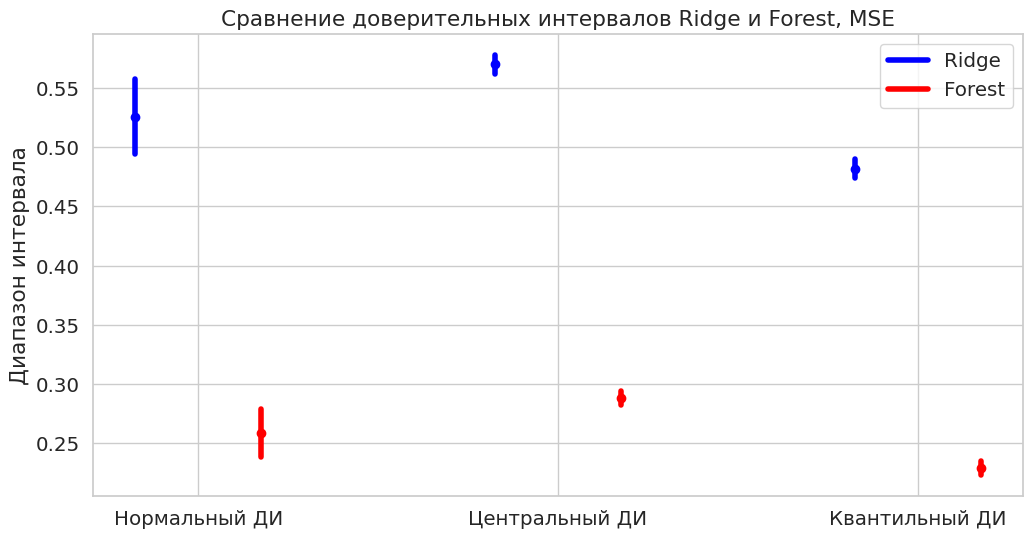

In [6]:
def print_confidence_intervals(ridge_intervals, forest_intervals, title_name):
    # Распаковка интервалов
    ridge_norm, ridge_central, ridge_q = ridge_intervals
    forest_norm, forest_central, forest_q = forest_intervals
    
    # Вывод числовых значений
    print(f"Ridge: Нормальный интервал: ({ridge_norm[0]:.2f}, {ridge_norm[1]:.2f})")
    print(f"Ridge: Центральный интервал: ({ridge_central[0]:.2f}, {ridge_central[1]:.2f})")
    print(f"Ridge: Квантильный интервал: ({ridge_q[0]:.2f}, {ridge_q[1]:.2f})")
    
    print(f"\nForest: Нормальный интервал: ({forest_norm[0]:.2f}, {forest_norm[1]:.2f})")
    print(f"Forest: Центральный интервал: ({forest_central[0]:.2f}, {forest_central[1]:.2f})")
    print(f"Forest: Квантильный интервал: ({forest_q[0]:.2f}, {forest_q[1]:.2f})")
    
    # Визуализация всех интервалов на одном графике
    plt.figure(figsize=(12, 6))
    
    # Позиции для Ridge и Forest на графике
    x_positions = np.array([0, 1, 2])  # Для каждого типа интервала
    width = 0.35  # Ширина столбца
    
    # Ridge intervals
    for i, (interval, name) in enumerate(zip([ridge_norm, ridge_central, ridge_q], 
                                           ['Нормальный', 'Центральный', 'Квантильный'])):
        plt.plot([x_positions[i]-width/2, x_positions[i]-width/2], interval, 'b-', linewidth=4, label='Ridge' if i==0 else "")
        plt.plot(x_positions[i]-width/2, np.mean(interval), 'bo')
    
    # Forest intervals
    for i, (interval, name) in enumerate(zip([forest_norm, forest_central, forest_q],
                                           ['Нормальный', 'Центральный', 'Квантильный'])):
        plt.plot([x_positions[i]+width/2, x_positions[i]+width/2], interval, 'r-', linewidth=4, label='Forest' if i==0 else "")
        plt.plot(x_positions[i]+width/2, np.mean(interval), 'ro')

    plt.xticks(x_positions, ['Нормальный ДИ', 'Центральный ДИ', 'Квантильный ДИ'])
    plt.ylabel("Диапазон интервала")
    plt.title(f"Сравнение доверительных интервалов Ridge и Forest, {title_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Вычисление интервалов
ridge_intervals = compute_confidence_interval(mse_sample_ridge)
forest_intervals = compute_confidence_interval(mse_sample_forest)

# Отображение результатов
print_confidence_intervals(ridge_intervals, forest_intervals, "MSE")


2. **MAPE**

Ridge: Нормальный интервал: (0.32, 0.39)
Ridge: Центральный интервал: (0.39, 0.40)
Ridge: Квантильный интервал: (0.31, 0.32)

Forest: Нормальный интервал: (0.16, 0.17)
Forest: Центральный интервал: (0.17, 0.17)
Forest: Квантильный интервал: (0.15, 0.16)


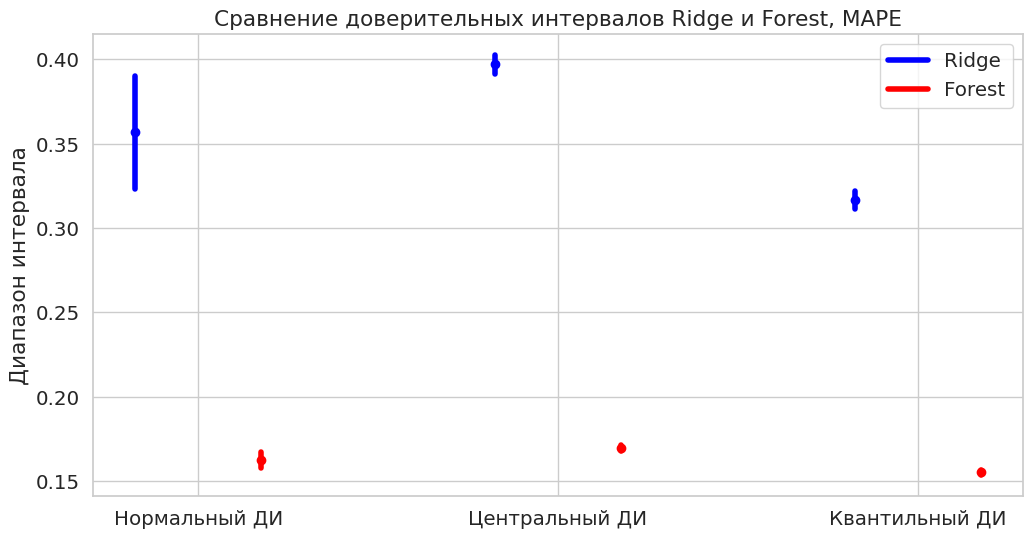

In [7]:
# Вычисление интервалов
ridge_intervals = compute_confidence_interval(mape_sample_ridge)
forest_intervals = compute_confidence_interval(mape_sample_forest)

# Отображение результатов
print_confidence_intervals(ridge_intervals, forest_intervals, "MAPE")

3. **MAE**

Ridge: Нормальный интервал: (0.52, 0.55)
Ridge: Центральный интервал: (0.55, 0.56)
Ridge: Квантильный интервал: (0.51, 0.52)

Forest: Нормальный интервал: (0.32, 0.34)
Forest: Центральный интервал: (0.34, 0.34)
Forest: Квантильный интервал: (0.31, 0.31)


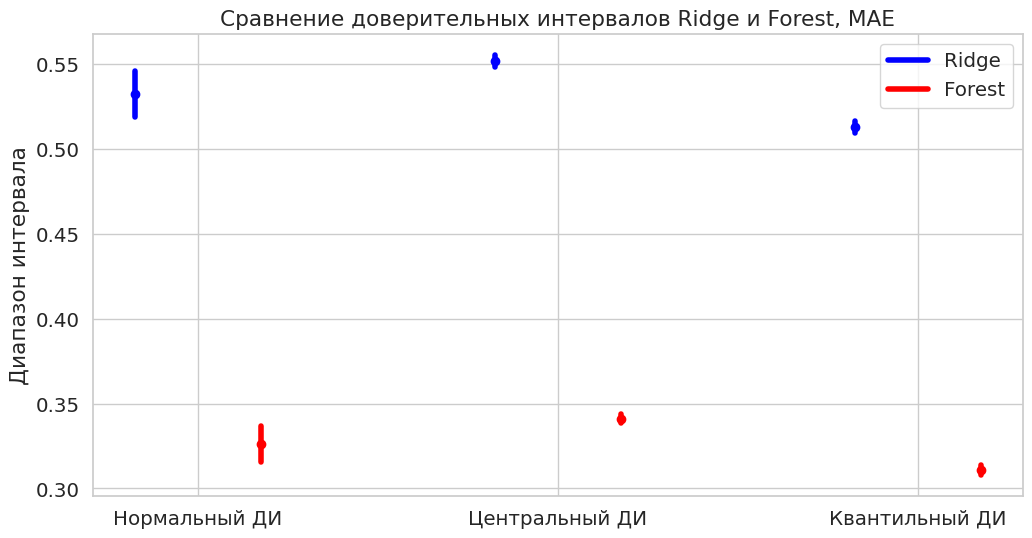

In [8]:
# Вычисление интервалов
ridge_intervals = compute_confidence_interval(mae_sample_ridge)
forest_intervals = compute_confidence_interval(mae_sample_forest)

# Отображение результатов
print_confidence_intervals(ridge_intervals, forest_intervals, "MAE")

<b><font color="#00b565" size="5">Конец исправлений</font></b>


<b><font color="#00b565" size="5">Добавил пояснения</font></b>

<b><font color="#00b565" size="3">Замечание:</font></b> Нет пояснений . Комм. Почему мы получили те или иные значения интервалов.



Используя формулы выведенные на лекции мы написали общую функцию, которая на выходе дает нам полученные интервалы.

<b><font color="#00b565" size="5">Конец исправлений</font></b>

<b><font color="#00b565" size="5">Добавил сравнение интервалов случайного леса и ридж регрессии</font></b>

<b><font color="#00b565" size="3">Замечание:</font></b> Нет сравнения интервалов случайного леса и рижд регрессии.

Как видим, интервалы для ридж регрессии отличаются от интервалов для случайного леса примерно в два раза.

Впрочем длины интервалы имеют сопостовимые размеры.

<b><font color="#00b565" size="5">Конец исправлений</font></b>


**Вывод:** Как видим, бутстрепный интервал покрывает истинные значения метрик как для Ridge регресии, так и для случайного леса, что говорит о корректности нашей реализации.

___
### Задача 2.

**1.** Сгенерируйте выборку $X_1, ..., X_{10000}$ из стандартного нормального распределения. Для каждого $n \leqslant 10000$ постройте эмпирическую функцию распределения $\widehat{F}_n$ и посчитайте **точное** значение статистики 

$$D_n = \sup\limits_{x \in \mathbb{R}} \left| \widehat{F}_n(x) - F(x) \right|.$$

Обоснуйте, почему при вашей реализации подсчета статистики полученное значение будет **точным**.

Постройте график зависимости статистики $D_n$ от $n$. Верно ли, что $D_n \to 0$ и в каком смысле?


Для выполнения задания можно использовать `statsmodels.distributions.empirical_distribution.ECDF`.

<b><font color="#00b565" size="5">Добавил пояснения к алгоритму</font></b>

<b><font color="#00b565" size="3">Замечание:</font></b> Нет пояснений по алгоритму. Комм. Нет обьяснения, как мы строим ЭФР, как находим пределы.



Разберемся как устроена эмпирическая функция распределения.

Мы знаем, что $\hat{F}_n(x)$ кусочно-постоянна, а $F$ &mdash; непрерывная и монотонно возрастает. Причем точки разрыва первой функции, это в точности элементы выборки $\{x_n\}$.

Отсюда следует, что супремум разности равен максимуму из односторонних пределов $\lim\limits_{x \rightarrow x_n+0} \left|\widehat{F}_n(x) - F(x)\right|$, $\lim\limits_{x \rightarrow x_n-0} \left|\widehat{F}_n(x) - F(x)\right|$ по всем точкам $\{x_n\}$


В первом случае предел справа &mdash; это значение $\widehat{F}_n(x)$, слева &mdash; $\left(\widehat{F}_n(x) - \frac{1}{n}\right)$. Во втором случае функция непрерывна и оба односторонних предела равны её значению в точке

<b><font color="#00b565" size="5">Конец исправлений</font></b>


In [9]:
n_sample = 10000
norm_dist = sps.norm(loc=0, scale=1)
X_sample = norm_dist.rvs(size=n_sample).ravel()


<b><font color="#00b565" size="5">Исправил ошибку в краевых случаях</font></b>

<b><font color="#00b565" size="3">Замечание:</font></b> Ошибка в краевых случаях. Комм. Не использованы пределы слева и справа.


In [10]:
D_n = []

for i in tqdm(range(1, n_sample + 1)):
    X_i = X_sample[:i]
    x_values = np.linspace(min(X_i), max(X_i), 1000)

    F_i = ECDF(X_i)
    right_limits = np.abs(F_i(x_values) - norm_dist.cdf(x_values))
    left_limits = np.abs((F_i(x_values) - 1./i) - norm_dist.cdf(x_values))

    D_n.append(max(right_limits.max(), left_limits.max()))

  0%|          | 0/10000 [00:00<?, ?it/s]

<b><font color="#00b565" size="5">Конец исправлений</font></b>

Значение статистики будет точным, так как $\arg \max$ статистики выражения находится на интервале от минимума выборки до максимума. Таким образом наша точность ограничена лишь точностью разбиения интервала.

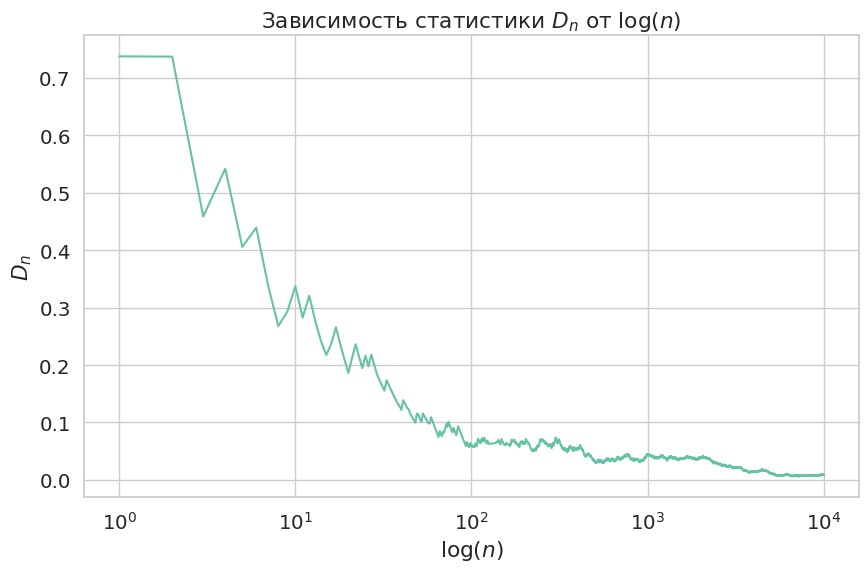

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_sample + 1), D_n)
plt.title(r"Зависимость статистики $D_n$ от $\log(n)$")
plt.xscale("log")
plt.xlabel(r"$\log(n)$")
plt.ylabel("$D_n$")
plt.grid(True)
plt.show()

**Вывод:** Как видим, $D_n \rightarrow 0$ почти наверное. Это прямое следствие теоремы Гливенко-Кантелли.

---

### Задача 3.

В этой задаче вы исследуете различные непараметрические оценки распределений.
Для этого вам выдается почти готовый код функций `draw_ecdf`, `draw_hist` и `draw_pdf`, которые используются для построения ЭФР, гистограммы и ядерной оценки плотности соответственно. В реализациях этих функция часть кода пропущена, вам нужно его дописать. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`.
При желании вы можете написать аналогичный код, используя реализацию в `seaborn`.

In [12]:
def draw_ecdf(sample, grid, cdf=None):
    """
    По сетке cтроит графики эмпирической функции распределения 
    и истинной (если она задана) для всей выборки и для 1/10 ее части.
    
    Вход:
        sample: выборка
        grid: сетка
        cdf: истинная функция распределения из scipy.stats
    """
    
    plt.figure(figsize=(16, 3))
    # Выбирается размер выборки
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        # Отрисовываются точки выборки на графике    
        plt.scatter(
            sample[:size],
            [0] * size,
            alpha=0.4, label='sample'
        )
        
        # Если передана истинная функция распределения, 
        # отрисовывается ее график
        if cdf is not None:
            plt.plot(
                grid,
                cdf(grid),
                color='green', alpha=0.3, lw=2, label='true cdf'
            )
        
        # Отрисовывается эмпирическую функцию распределения
        ecdf = ECDF(sample[:size]) 
        plt.plot(
            grid,
            ecdf(grid),
            color='red', label='ecdf'
        )
        
        plt.legend()
        plt.grid(ls=':')
        plt.title('sample size = {}'.format(size))
    plt.show()

In [13]:
def draw_hist(sample, grid, pdf=None):
    """
    Строит гистограмму и, по сетке, график истинной плотности 
    (если она задана) для всей выборки и для 1/10 ее части.
    
    Вход:
        sample: выборка
        grid: сетка
        pdf: истинная плотность из scipy.stats
    """
    
    plt.figure(figsize=(16, 3))
    # Выбирается размер выборки
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        # Построение гистограммы для выборки
        plt.hist(
            sample[:size], 
            bins = 20,
            range=(grid.min(), grid.max()),
            density=True, label='sample hist'
        )
        
        # Если передана истинная плотность, отрисовывается ее график
        if pdf is not None:
            plt.plot(
                grid,
                pdf(grid),
                color='green', alpha=0.3, lw=2, label='true pdf'
            )
        
        plt.legend()
    plt.show()

In [14]:
def draw_pdf(sample, grid, pdf=None):
    """
    По сетке cтроит графики ядерной оценки плотности 
    и истинной плотности (если она задана) для всей выборки 
    и для 1/10 ее части.
    
    Вход:
        sample: выборка
        grid: сетка
        pdf: истинная плотность из scipy.stats
    """
    
    plt.figure(figsize=(16, 3))
    # Выбирается размер выборки
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        # Отрисовка точек выборки на графике
        plt.scatter(
            sample[:size], [0] * size,
            alpha=0.4, label='sample'
        )
        
        # Если передана истинная плотность, отрисовывается ее график
        if pdf is not None:
            plt.plot(
                grid,
                pdf(grid), 
                color='green', alpha=0.3, lw=2, label='true pdf'
            )
        
        # Отрисовывается KDE
        kde = KDEUnivariate(sample[:size])  
        kde.fit()
        plt.plot(
            grid,
            kde.evaluate(grid),
            color='red', label='kde'
        )
        
        plt.legend()
        plt.grid(ls=':')
    plt.show()

Используя реализованные выше функции, постройте график эмпирической функции распределения (ЭФР), гистограмму и график ядерной оценки плотнотности к выборкам размера 500 для следующих распределений:

In [15]:
n_samples = 500

In [16]:
def show_graphs(grid, distribution, n_samples = 500):
    X_sample = distribution.rvs(size=n_samples)
    draw_ecdf(X_sample, grid, distribution.cdf)
    draw_hist(X_sample, grid, distribution.pdf)
    draw_pdf(X_sample, grid, distribution.pdf)

*1. Равномерное распределение $U[0,1]$*. Графики функции распределения и плотностей строить на интервале $(-0.2, 1.2)$.

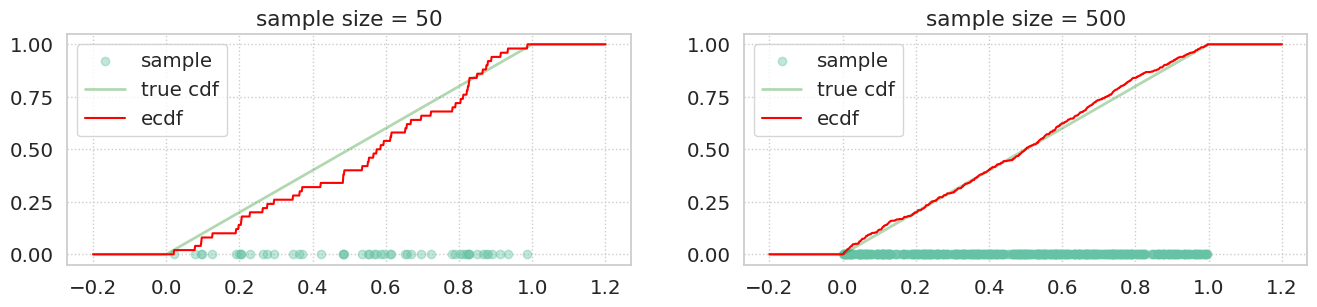

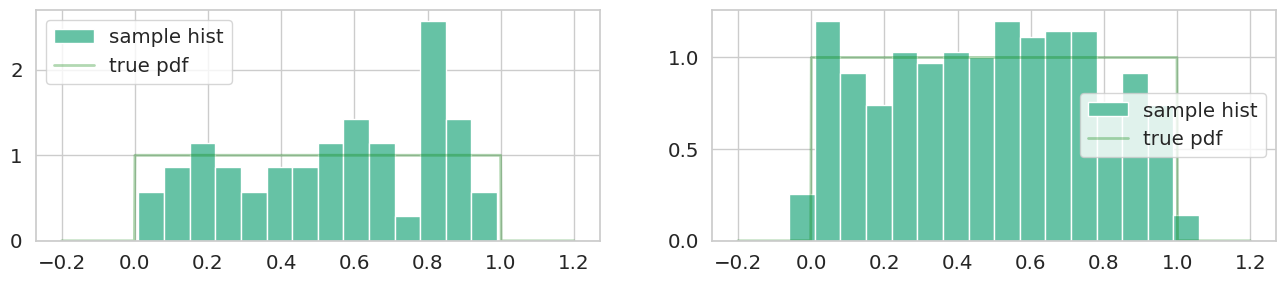

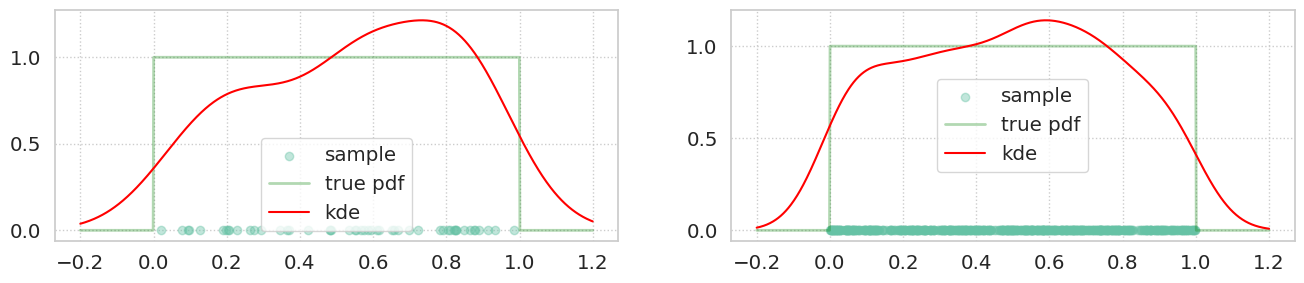

In [17]:
uniform_dist = sps.uniform(loc = 0, scale = 1)
grid = np.linspace(-0.2, 1.2, 1000)

show_graphs(grid, uniform_dist)

*2. Нормальное распределение $\mathcal{N}(0, 1)$.* Графики функции распределения и плотностей строить на интервале $(-3, 3)$.

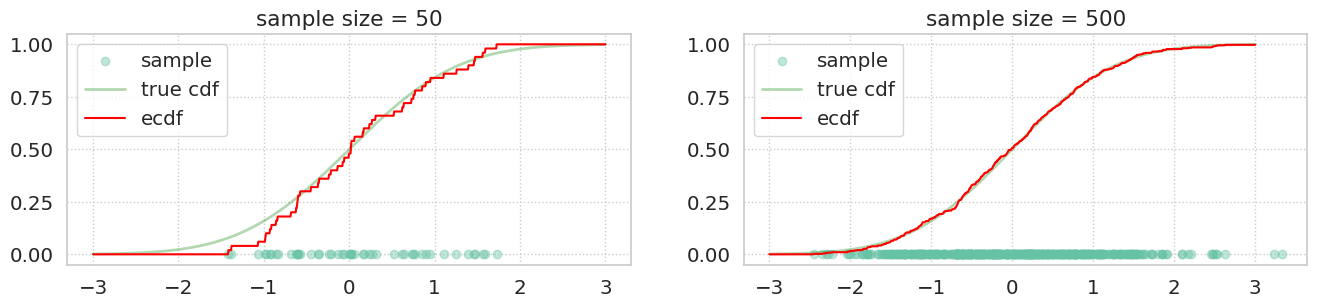

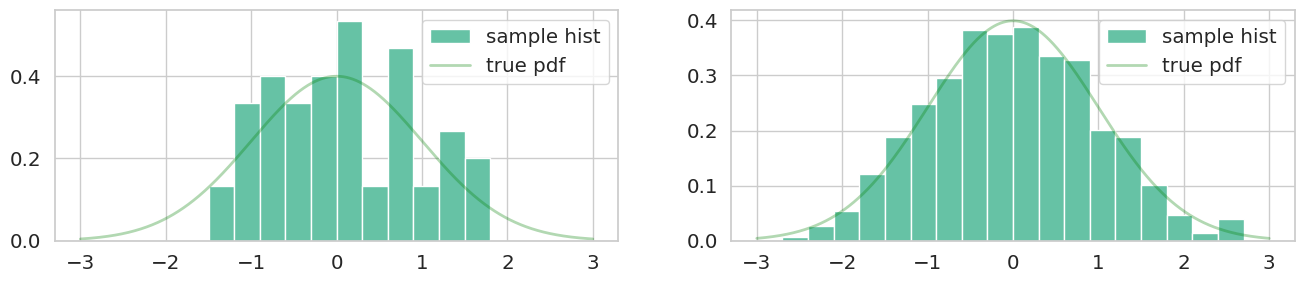

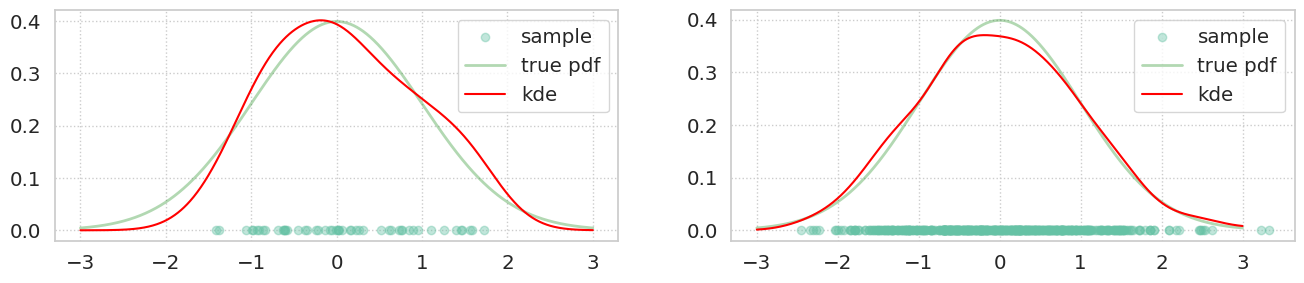

In [18]:
norm_dist = sps.norm(loc=0, scale=1)
grid = np.linspace(-3, 3, 1000)
show_graphs(grid, norm_dist)

*3. Экспоненциальное распределение $Exp(1)$.* Графики функции распределения и плотностей  строить на интервале $(-0.5, 5)$.

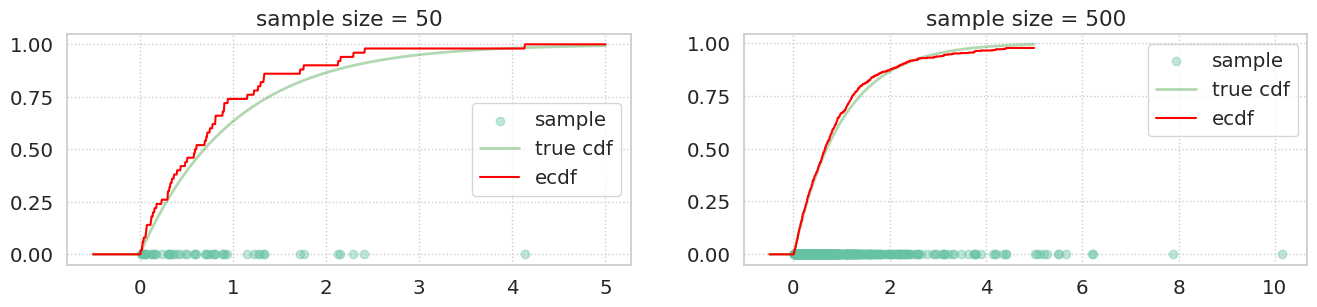

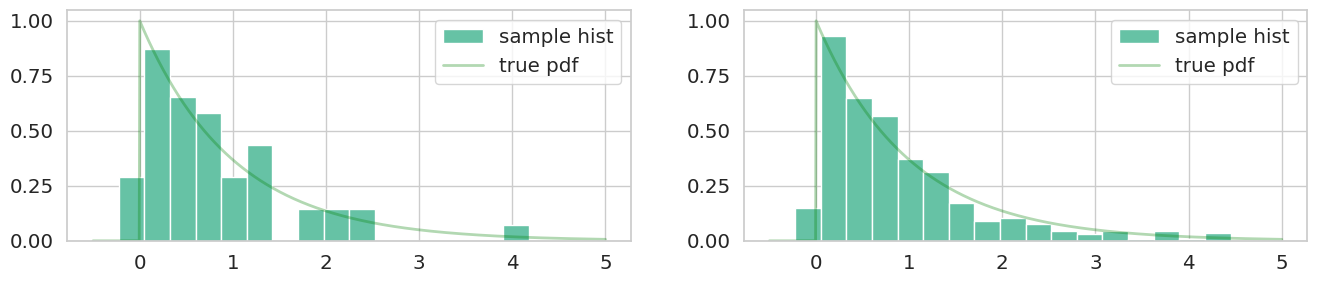

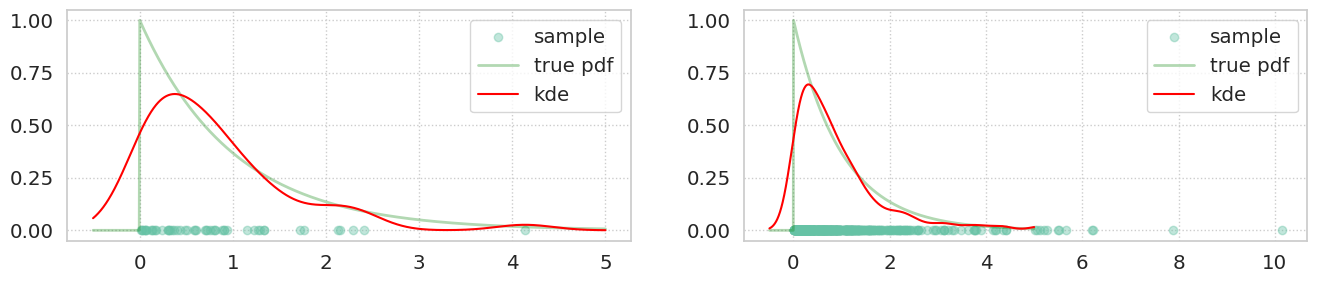

In [19]:
exp_dist = sps.expon(scale=1)
grid = np.linspace(-0.5, 5, 1000)
show_graphs(grid, exp_dist)

Опишите полученные результаты, сравните их между выборками из различных распределений.

**Вывод:**

* Можно заметить, что эмпирическая функция распределения хорошо повторяет распределения с непрерывной плотностью (в нашем случае оно одно). но в случае если плотность имеет разрыв, мы видим, что эмиприческая плотность пытается ее сгладить, из за чего в точках близки к разрыву ее значение отличается от истинного

* Мы видим, что в случае нормального и экспоненциального распределений ЭФР их хорошо повторяет, в то время как в случае равномерного распределения наблюдается сглаживание, из за чего ЭФР сильно отличается от истинной даже на большой выборке.

---
### Задача 4.

Исследуйте вид ядерной оценки плотности в зависимости от вида ядра и его ширины.

Для этого сгенерируйте выборку $X_1, ..., X_{200}$ из распределения $U[0, 1]$ и постройте серию графиков для различной ширины гауссовского ядра, а затем другую серию графиков для различных типов ядер при фиксированной ширине. На каждом графике на отрезке $[-0.2, 1.2]$ должны быть изображены истинная плотность (полупрозрачным цветом) и ее ядерная оценка, а так же с нулевой $y$-координатой должны быть нанесены точки выборки. Для экономии места стройте графики в два столбца.

Вам выдется почти готовый код для выполнения задания с некоторыми пропусками. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`. При желании вы можете написать аналогичный код, используя реализацию в `seaborn`. При построении KDE разрешается использовать цикл.

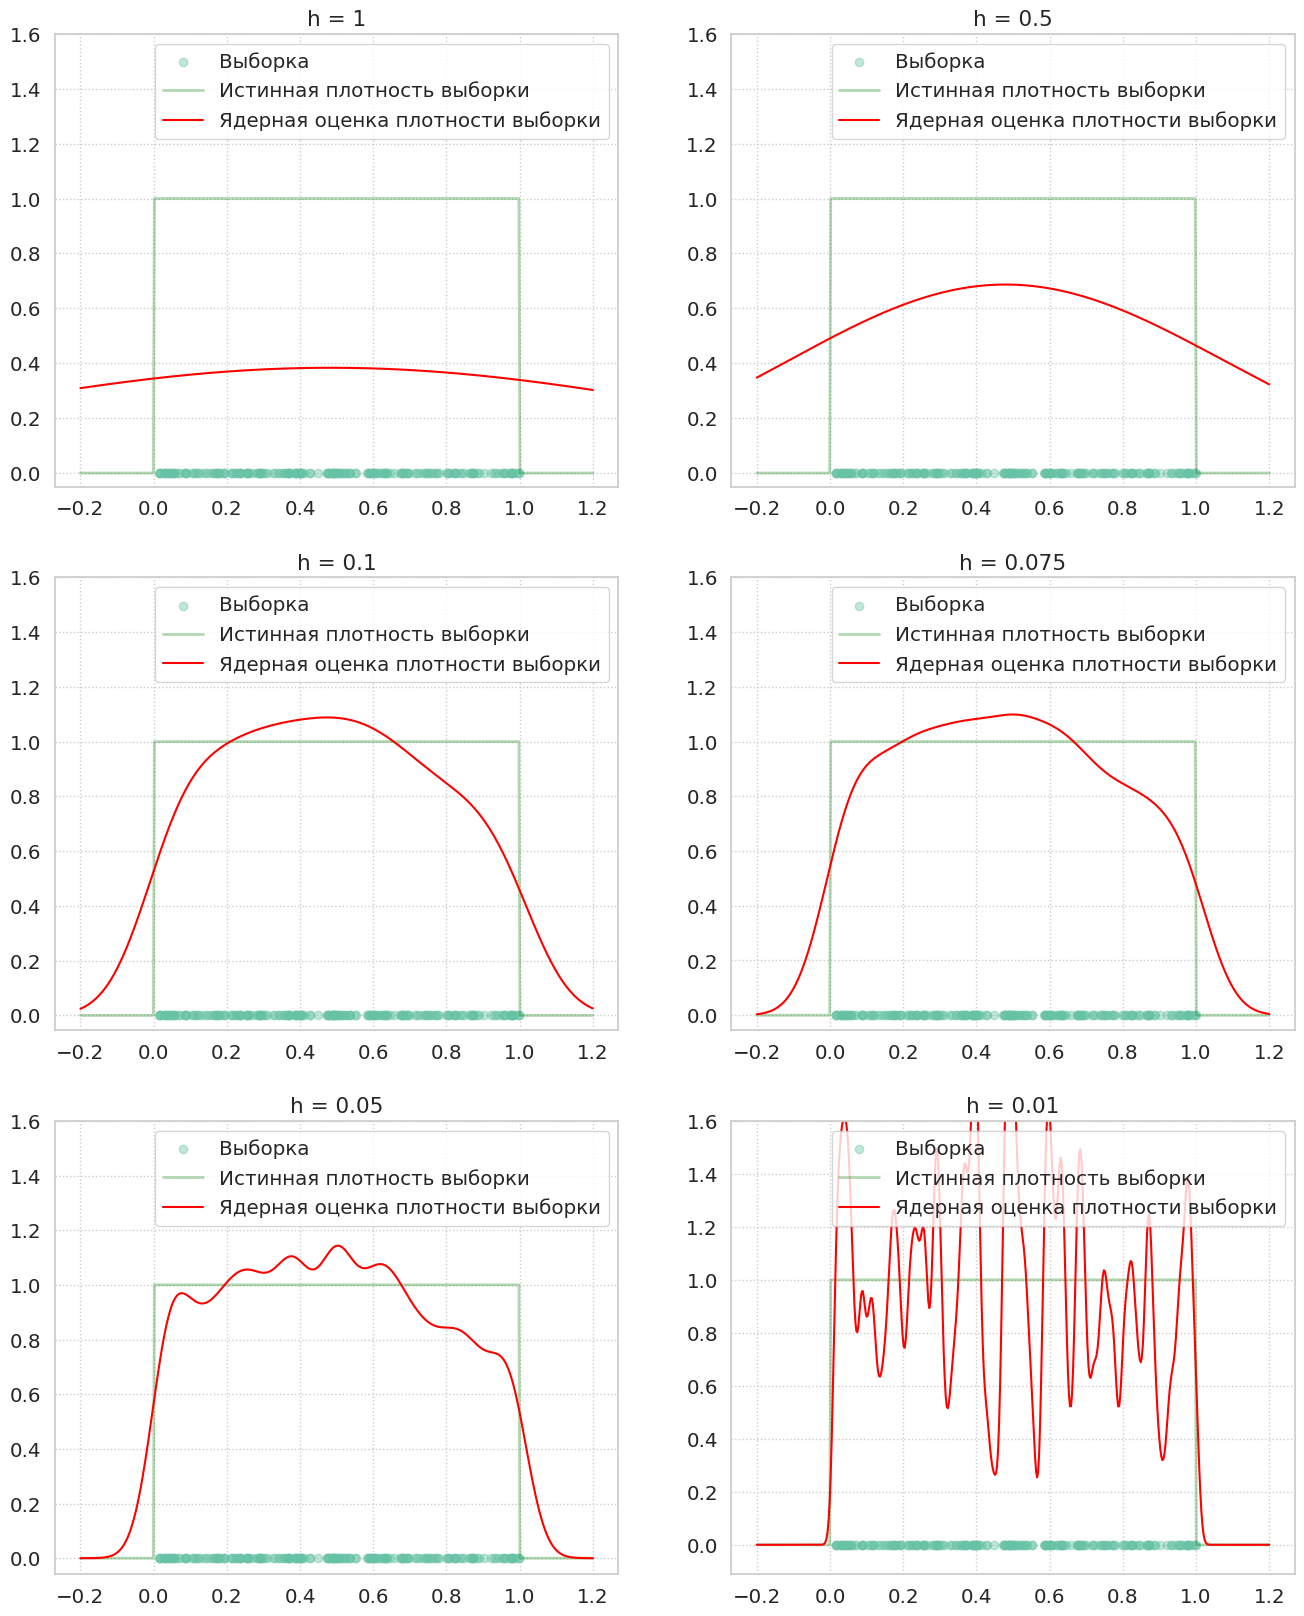

In [20]:
# Размер выборки
size = 200
# Выборка размера size
uniform_dist = sps.uniform(loc = 0, scale = 1)
sample = uniform_dist.rvs(size=size)
# Сетка на отрезке из условия
grid = np.linspace(-0.2, 1.2, 500)

plt.figure(figsize=(16, 20))

# Итераций по ширине ядра
for i, bw in enumerate([1, 0.5, 0.1, 0.075, 0.05, 0.01]):
    plt.subplot(3, 2, i + 1)
    # Построение KDE
    kernel_density = KDEUnivariate(sample)
    kernel_density.fit(bw=bw)
    # Отображение элементов выборки
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='Выборка')
    # Построение истинной плотности выборки
    plt.plot(grid, uniform_dist.pdf(grid), color='green', 
             alpha=0.3, lw=2, label='Истинная плотность выборки')
    # Отображение KDE плотности
    plt.plot(grid, kernel_density.evaluate(grid), 
             color='red', label='Ядерная оценка плотности выборки')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title('h = {}'.format(bw))
    plt.ylim((None, 1.6))
plt.show()

Во втором случае графики постройте аналогичным образом, проведя итерации по типу ядра.

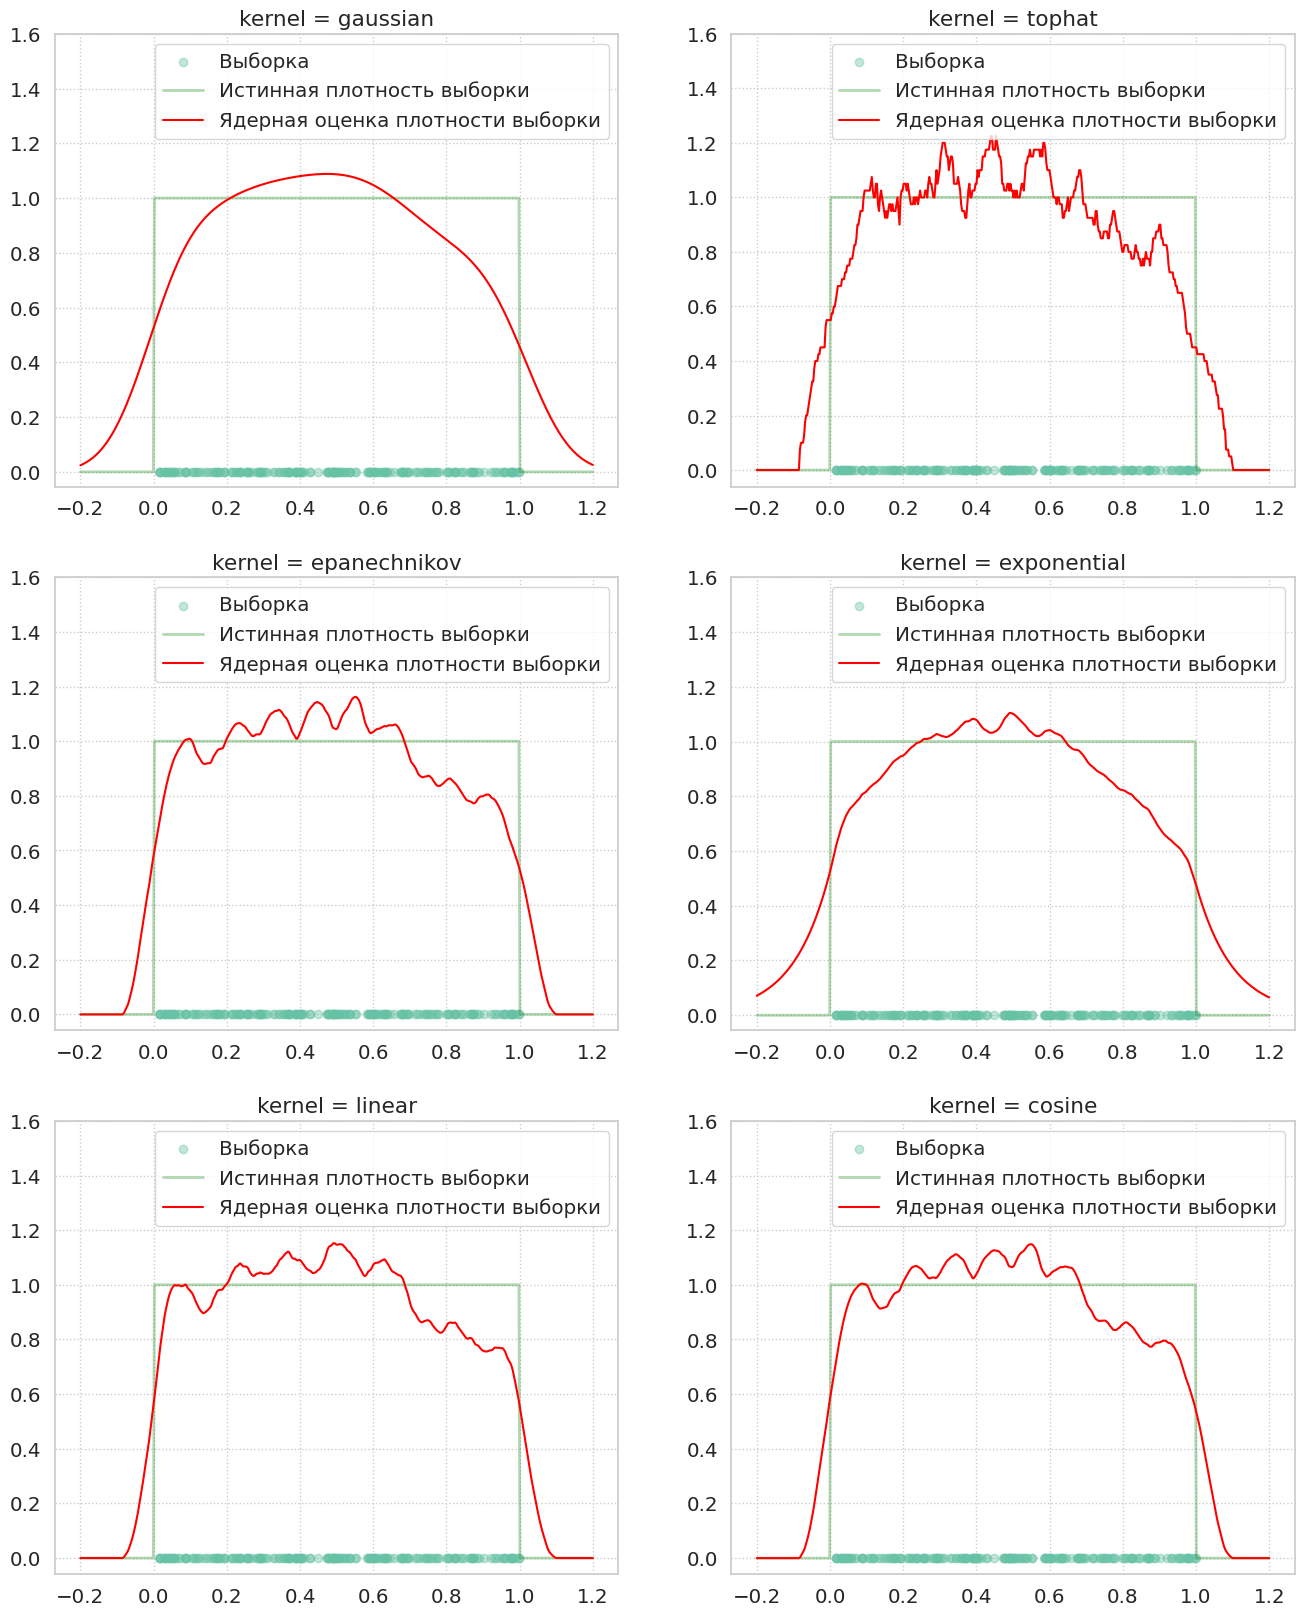

In [21]:
kernels_type = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
bw = 0.1

plt.figure(figsize=(16, 20))

for i, kernel_name in enumerate(kernels_type):
    plt.subplot(3, 2, i + 1)
    # Построение KDE
    kernel_density = KernelDensity(kernel=kernel_name, bandwidth=bw)
    kernel_density.fit(sample.reshape(-1, 1))
    # Отображение элементов выборки
    plt.scatter(sample, np.zeros(size), alpha=0.4, label="Выборка")
    # Построение истинной плотности выборки
    plt.plot(
        grid,
        uniform_dist.pdf(grid),
        color="green",
        alpha=0.3,
        lw=2,
        label="Истинная плотность выборки",
    )
    # Отображение KDE плотности
    plt.plot(
        grid,
        np.exp(kernel_density.score_samples(grid.reshape(-1, 1))),
        color="red",
        label="Ядерная оценка плотности выборки",
    )
    plt.legend(loc=1)
    plt.grid(ls=":")
    plt.title(f"kernel = {kernel_name}")
    plt.ylim((None, 1.6))
plt.show()

**Вывод:**

* Как видно с первой серии графиков. При слишком большой ширине ядра ядерная оценка не аппроксимирует истинную плотность, с уменьшением ширины, она все больше подходит под истинную плотность, вплоть до переобучения, когда ядерная оценка в силу узости сильно реагирует на любые пустоты или пучности точек.

* Заметим что гаусовское и экспоненциальное ядра мало подвержены выбросам, в отличии от остальных представленных ядер.
Особенно остро на пустоты и пучности реагируют линейное и прямоугольное ядра.

---
### Задача 5.

Рассмотрим задачу регрессии. Мы уже научились оценивать зависимость $y(x)$, но это только точечная оценка для каждого конкретного $x$. На практике бывает необходимо строить доверительные интервалы, которые в совокупности образуют доверительные ленты. Поскольку мы ничего не знаем про распределение ошибок, будем строить доверительную ленту по методу бутстрепа.

1. Сгенерируем достаточно большое число бутстрепных выборок.

2. Обучим модели и получим значения $\widehat{y}(x)$, для всех значений $x$ по сетке значений.

3. По предсказаным значениям оценим верхнюю и нижнюю границы ленты с помощью методов построения бутстрепных доверительных интервалов.

Напишите функцию, которая реализует данный метод

In [22]:
from numpy.linalg import LinAlgError

def bootstrap_confidence_interval(
    X, Y, model, X_grid, bootstrap_count=None, alpha=0.95, model_args=None
):
    '''
    Построение предсказательной ленты для модели регрессии.
    
    X, Y - выборка;
    model - класс модели;
    X_grid - сетка для доверительной ленты;
    alpha - уровень доверия;
    bootstrap_count - количество бутстрепных выборок;
    model_args - параметры модели.
    '''
    
    bootstrap_count = bootstrap_count or X.shape[0]
    predictions = []

    for _ in tqdm(range(bootstrap_count)):
        try:
            # Генерация бутстрепной выборки и обучение модели
            X_bootstrap, Y_bootstrap = resample(X, Y)
            model_instance = model(**model_args) if model_args else model()
            model_instance.fit(X_bootstrap, Y_bootstrap)

            # Предсказания для X_grid
            predictions.append(model_instance.predict(X_grid))
        
        except (LinAlgError, ZeroDivisionError):
            continue

    # Вычисляем доверительные интервалы
    lower_bound = np.percentile(predictions, (1 - alpha) / 2 * 100, axis=0)
    upper_bound = np.percentile(predictions, (1 + alpha) / 2 * 100, axis=0)
    
    return lower_bound, upper_bound

Рассмотрим датасет cps71 из семинара

In [23]:
data = pd.read_csv('cps71.csv', index_col=0)
data.dropna(inplace=True)
data.head()

,logwage,age
1,11.1563,21
2,12.8131,22
3,13.0960,22
4,11.6952,22
5,11.5327,22


Разделим нашу выборку на обучающую и тестовую

In [24]:
X = data['age'].values.reshape(-1, 1)
y = data['logwage'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Постройте доверительные ленты для моделей линейной регрессии, ядерной регрессии и KNN-регрессии.
Изобразите на графике также предсказания каждой модели и обучающую выборку.

*Примечание: для классов из statmodels сигнатура класса может не совпадать со стандартной, поэтому сделайте для этих классов, класс-обертку, который в себе просто будет вызывать нужные методы.*

In [25]:
class LinearRegression:
    def __init__(self, alpha=0):
        self.model = Ridge(alpha=alpha)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self.model

    def predict(self, X):
        return self.model.predict(X)


class KernelRegressionWrapper:
    def __init__(self, bw=[0.3]):
        self.model = None
        self.bw = bw

    def fit(self, X, y):
        self.model = KernelReg(endog=y, exog=X, var_type="c", bw=self.bw)

    def predict(self, X):
        pred, _ = self.model.fit(X.squeeze())
        return pred

In [26]:
X_grid = np.linspace(X_train.min(), X_train.max(), 1000).reshape(-1, 1)

lower_kernel, upper_kernel = bootstrap_confidence_interval(
    X_train, y_train, KernelRegressionWrapper, X_test, bootstrap_count=X_train.shape[0] * 2
)
lower_linreg, upper_linreg = bootstrap_confidence_interval(
    X_train, y_train, LinearRegression, X_test, bootstrap_count=X_train.shape[0] * 2
)
lower_knn, upper_knn = bootstrap_confidence_interval(
    X_train, y_train,KNeighborsRegressor, X_test, bootstrap_count=X_train.shape[0] * 2
)

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

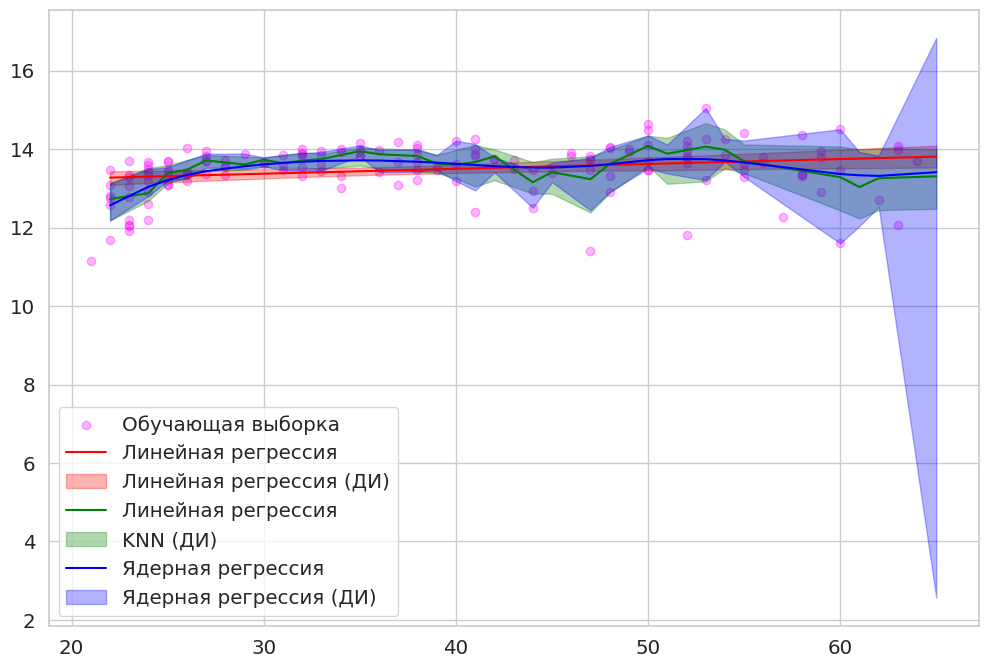

In [27]:
plt.figure(figsize=(12, 8))

plt.scatter(X_train, y_train, color="magenta", alpha=0.3, label="Обучающая выборка")

# Линейная регрессия
linreg_model = LinearRegression().fit(X_train, y_train)
sorted_idx = np.argsort(X_test.squeeze())
plt.plot(
    X_test[sorted_idx],
    linreg_model.predict(X_test[sorted_idx]),
    ls="-",
    color="red",
    label="Линейная регрессия",
)
plt.fill_between(
    X_test.squeeze()[sorted_idx],
    lower_linreg[sorted_idx].reshape(-1),
    upper_linreg[sorted_idx].reshape(-1),
    color="red",
    alpha=0.3,
    label="Линейная регрессия (ДИ)",
)
# KNN
knn_model = KNeighborsRegressor().fit(X_train, y_train)
sorted_idx = np.argsort(X_test.squeeze())
plt.plot(
    X_test[sorted_idx],
    knn_model.predict(X_test[sorted_idx]),
    ls="-",
    color="green",
    label="Линейная регрессия",
)
plt.fill_between(
    X_test.squeeze()[sorted_idx],
    lower_knn[sorted_idx].reshape(-1),
    upper_knn[sorted_idx].reshape(-1),
    color="green",
    alpha=0.3,
    label="KNN (ДИ)",
)

# Ядерная регрессия
kernel_reg = KernelRegressionWrapper(bw="cv_ls")
kernel_reg.fit(X_train, y_train)
sorted_idx = np.argsort(X_test.squeeze())
plt.plot(
    X_test[sorted_idx],
    kernel_reg.predict(X_test[sorted_idx]),
    color="blue",
    label="Ядерная регрессия",
    ls="-",
)
plt.fill_between(
    X_test.squeeze()[sorted_idx],
    lower_kernel[sorted_idx].reshape(-1),
    upper_kernel[sorted_idx].reshape(-1),
    color="blue",
    alpha=0.3,
    label="Ядерная регрессия (ДИ)",
)

plt.legend()
plt.show()

Сделайте выводы

**Вывод:**

Как видим, ДИ для KNN и ядерной регрессии действительно покрывают значительное количество точек, что может говорить о корректной реализации предложенного алгоритма, а также то, что данные способы аппроксимации хорошо отражают природу данных.

Видим, что линейная регрессия плохо аппрокисимируют данный датасете, вследствие чего покрытие ДИ явно не соответсует заявленному уровню доверия.